#sparksql

In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd


data = [("James","Smith","USA","CA"),("Michael","Rose","USA","NY"),
    ("Robert","Williams","USA","CA"),("Maria","Jones","USA","FL")
  ]
columns=["firstname","lastname","country","state"]
df=spark.createDataFrame(data=data,schema=columns)
#df.printSchema()
df.show()
#print(df.collect())


from pyspark.sql.functions import col,expr
data=[("2019-01-23",1),("2019-06-24",2),("2019-09-20",5)]
spark.createDataFrame(data).toDF("date","increment") \
    .select(col("date"),col("increment"), \
      expr("add_months(to_date(date,'yyyy-MM-dd'),cast(increment as int))").alias("inc_date")) \
    .show()

from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

schema = StructType([
            StructField("seq", StringType(), True)])

# Modify the data to be a list of strings
dates = [['1']]  # Now a list containing a single-element list

df = spark.createDataFrame(dates, schema=schema)

df.show()

#pyspark with pipeine

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import pyspark.sql.types as tp
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

#read csv file
my_data=spark.read.csv('/content/drive/MyDrive/diabetes.csv',header=True)

my_data.show()


#see the schema
my_data.printSchema()


my_schema=tp.StructType(
    [
        tp.StructField('Pregnancies',tp.IntegerType(),True),
        tp.StructField('Glucose',tp.IntegerType(),True),
        tp.StructField('BloodPressure',tp.IntegerType(),True),
        tp.StructField('SkinThickness',tp.IntegerType(),True),  # values like 1,2,
        tp.StructField('Insulin',tp.IntegerType(),True),
        tp.StructField('BMI',tp.FloatType(),True),    # values like 0.1,9.2
        tp.StructField('DiabetesPedigreeFunction',tp.FloatType(),True),
        tp.StructField('Age',tp.IntegerType(),True),
        tp.StructField('Outcome',tp.IntegerType(),True)
    ]
)

my_data=spark.read.csv('/content/drive/MyDrive/diabetes.csv',header=True,schema=my_schema)
my_data.printSchema()


#get dimension of data
(my_data.count(),len(my_data.columns))

my_data.head()


#Replace zero with null for filling missing values
from pyspark.sql.functions import when, col

def replace_zero_with_null(df):
    for i, column_name in enumerate(df.columns):
        # Skip first and last column
        if i == 0 or i == len(df.columns) - 1:
            continue
        df = df.withColumn(column_name, when(col(column_name) == 0, None).otherwise(col(column_name)))
    return df

my_data = replace_zero_with_null(my_data)
my_data.show()




#impute values in null place in
imputer = Imputer(
    inputCols=my_data.columns,
    outputCols=my_data.columns
    ).setStrategy("median")

my_data1 = imputer.fit(my_data).transform(my_data)



my_data1.show()




# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['Pregnancies',
                                       'Glucose',
                                       'BloodPressure',
                                       'SkinThickness',
                                       'Insulin', 'BMI',
                                       'DiabetesPedigreeFunction',
                                       'Age'],
                             outputCol='features')

final_data = assembler.transform(my_data1)
final_data.select('features', 'Outcome').show()


#split data for test and train
train_data,test_data=final_data.randomSplit([0.8,0.2])


#train the model
lr=LogisticRegression(featuresCol='features',labelCol='Outcome', maxIter=10)
model=lr.fit(train_data)


#test model
prediction=model.transform(test_data)
prediction.show(5)


#create a pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[replace_zero_with_null,imputer, assembler, lr])
pipeline_model = pipeline.fit(my_data1)
pred = pipeline_model.transform(my_data1)
pred.show(5)


#create new data for prediction with outcome column
Pregnancies=1
Glucose=166
BloodPressure=72
SkinThickness=15
Insulin=17
BMI=33.6
DiabetesPedigreeFunction=0.627
Age=50
# Add a placeholder value for 'Outcome' (you'll need to determine the appropriate value based on your problem)
Outcome = 0
new_data=spark.createDataFrame([(Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age, Outcome)],
                               ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age', 'Outcome'])
new_data.show()


#predicte new data through pipline
pipeline_model.transform(new_data).show()






#AMS

In [ ]:
stream = [2, 3, 7, 1, 5, 8, 5, 7, 9, 6, 4, 4, 5, 6, 5, 8, 8, 5, 2, 2, 2, 1, 1, 6, 7]  # Given stream values
x_values = [1, 3, 5, 10]  # 1-indexed positions

# Create a dictionary to store the result
result = {}

# Length of the stream
stream_length = len(stream)

# Loop through the x_values and process each
for pos in x_values:
    index = pos # Convert to 0-indexed
    if index < stream_length:
        value_at_position = stream[index]
        count_in_stream = stream.count(value_at_position)
        estimate = stream_length * (2 * count_in_stream - 1)
        result[pos] = {
            "x.el": value_at_position,
            "x.val": count_in_stream,
            "estimate": estimate
        }

# Separate estimate values from result
estimates = [info["estimate"] for info in result.values()]

# Calculate the average of estimates
average_estimate = sum(estimates) / len(estimates) if estimates else 0

# Output the result and average estimate
print("Result Dictionary:")
print(result)
print("\nEstimates List:")
print(estimates)
print("\nAverage Estimate:")
print(average_estimate)


#bloom filter

In [ ]:
def hash1(x):
    return (x + 1) % 17
def hash2(x):
    return (3 * x + 2) % 17
# Initialize bit array and elements
size = 18
bit_array = [0] * size
elements = [15, 10, 3]
# Add elements to Bloom filter
for x in elements:
    bit_array[hash1(x) % size] = 1
    bit_array[hash2(x) % size] = 1

ne=[5,1,3]
# Check each element in the Bloom filter
print(bit_array)
for x in ne:
    if bit_array[hash1(x)] == 1 and bit_array[hash2(x)] == 1:
        print(f"{x} is likely present in the set.")
    else:
        print(f"{x} is not present in the set.")

#flajolet martin

In [ ]:
def hash_function1(x):
    return (3 * x + 7) % 32

def hash_function2(x):
    return (5 * x + 11) % 32

def to_binary_string(value, bit_length=5):
    return format(value, f'0{bit_length}b')

def count_trailing_zeros(binary_value):
    return len(binary_value) - len(binary_value.rstrip('0'))

# Elements to process
elements = [3, 1, 4, 3, 7, 8]

# Prepare table data
table_data = []
max_power_of_two1 = 0  # Initialize the maximum value of 2^r for hash function 1
max_power_of_two2 = 0  # Initialize the maximum value of 2^r for hash function 2

for element in elements:
    # Compute hash values for both functions
    hash_value1 = hash_function1(element)
    hash_value2 = hash_function2(element)

    # Convert hash values to binary
    binary_value1 = to_binary_string(hash_value1)
    binary_value2 = to_binary_string(hash_value2)

    # Count trailing zeros
    r1 = count_trailing_zeros(binary_value1)
    r2 = count_trailing_zeros(binary_value2)

    # Compute power of two
    power_of_two1 = 2 ** r1
    power_of_two2 = 2 ** r2

    # Update maximum power of two values
    max_power_of_two1 = max(max_power_of_two1, power_of_two1)
    max_power_of_two2 = max(max_power_of_two2, power_of_two2)

    # Append row data
    table_data.append((element, hash_value1, binary_value1, r1, power_of_two1,
                       hash_value2, binary_value2, r2, power_of_two2))

# Print table headers
print(f"{'Element':<8} | {'Hash 1 Value':<12} | {'Binary 1 Value':<14} | {'Trailing Zeros 1':<17} | {'2^r1':<6} | {'Hash 2 Value':<12} | {'Binary 2 Value':<14} | {'Trailing Zeros 2':<17} | {'2^r2':<6}")
print("-" * 90)

# Print table rows
for element, hash_value1, binary_value1, r1, power_of_two1, hash_value2, binary_value2, r2, power_of_two2 in table_data:
    print(f"{element:<8} | {hash_value1:<12} | {binary_value1:<14} | {r1:<17} | {power_of_two1:<6} | {hash_value2:<12} | {binary_value2:<14} | {r2:<17} | {power_of_two2:<6}")

# Compute and print the average of the maximum values of 2^r for both hash functions
average_max_power_of_two = (max_power_of_two1 + max_power_of_two2) / 2
print(f"\nMaximum value of 2^r for Hash Function 1: {max_power_of_two1}")
print(f"Maximum value of 2^r for Hash Function 2: {max_power_of_two2}")
print(f"Average of the maximum values of 2^r: {average_max_power_of_two}")


#Bipartite with normal

In [ ]:
from networkx.algorithms import bipartite


!pip install networkx



import networkx as nx
import matplotlib.pyplot as plt
# Create the bipartite graph using a simplified approach
B = nx.Graph()
edges = [(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")]
B.add_edges_from(edges)  # Automatically adds nodes when adding edges

# Set the positions for the nodes using bipartite_layout (nodes from the first set of edges are used as top nodes)
pos = nx.bipartite_layout(B, [1, 2, 3, 4])
# Draw the graph with labels
nx.draw(B, pos=pos, with_labels=True)
# Show the plot
plt.show()
nx.is_connected(B)



# Check if the graph is bipartite
is_bipartite = nx.is_bipartite(B)
print(f"Is the graph bipartite? {is_bipartite}")

# Perform bipartite matching
matching = nx.bipartite.maximum_matching(B)

# Set node positions using bipartite_layout
pos = nx.bipartite_layout(B, [1, 2, 3, 4])

# Draw the graph with labels
nx.draw(B, pos=pos, with_labels=True)

# Highlight the matched edges in red
nx.draw_networkx_edges(
    B,
    pos=pos,
    edgelist=matching.items(),
    width=3,
    edge_color="red",
)

# Show the plot
plt.show()


#bipartite with csv

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the CSV data
df = pd.read_csv('/content/Book1.csv')

# Create an empty graph
B = nx.Graph()

# Add nodes with the bipartite attribute
B.add_nodes_from(df['source'], bipartite=0)  # Set 1
B.add_nodes_from(df['target'], bipartite=1)  # Set 2

# Add edges between the nodes
edges = list(zip(df['source'], df['target']))
B.add_edges_from(edges)

# Draw the bipartite graph
pos = nx.bipartite_layout(B, df['source'])

 # Position layout for bipartite graph
nx.draw(B, pos, with_labels=True, node_color=['lightblue' if n in df['source'].values else 'lightgreen' for n in B.nodes()])
plt.show()



# Check if the graph is bipartite
is_bipartite = nx.is_bipartite(B)
print(f"Is the graph bipartite? {is_bipartite}")

# Perform bipartite matching
matching = nx.bipartite.maximum_matching(B)

# Set node positions using bipartite_layout
pos = nx.bipartite_layout(B, [1, 2, 3, 4])

# Draw the graph with labels
nx.draw(B, pos=pos, with_labels=True)

# Highlight the matched edges in red
nx.draw_networkx_edges(
    B,
    pos=pos,
    edgelist=matching.items(),
    width=3,
    edge_color="red",
)

# Show the plot
plt.show()


#ksingles minhashing

In [ ]:
# Use raw string literals for Windows paths
file1_path = r'/content/sample_data/text1.txt'
file2_path = r'/content/sample_data/text2.txt'
file3_path = r'/content/sample_data/text3.txt'

# Function to read a text file
def read_text_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

# Read each text file
text1 = read_text_file(file1_path)
text2 = read_text_file(file2_path)
text3 = read_text_file(file3_path)

# Display the content of each text file
print("Text 1:")
print(text1)
print("\nText 2:")
print(text2)
print("\nText 3:")
print(text3)




def create_k_shingles(text, k):
    words = text.split()
    shingles = []
    for i in range(len(words) - k + 1):
        shingle = " ".join(words[i:i+k])
        shingles.append(shingle)
    return shingles


# Create 5-shingles for each text file
k = 5
shingles_text1 = create_k_shingles(text1, k)
shingles_text2 = create_k_shingles(text2, k)
shingles_text3 = create_k_shingles(text3, k)

# Display the 5-shingles from each text file
print("5-shingles from text1:")
for shingle in shingles_text1:
    print(shingle)

print("\n5-shingles from text2:")
for shingle in shingles_text2:
    print(shingle)

print("\n5-shingles from text3:")
for shingle in shingles_text3:
    print(shingle)



# Combine all shingles to create a set of all unique shingles
all_shingles = set(shingles_text1).union(set(shingles_text2)).union(set(shingles_text3))

# Create the incidence matrix
incidence_matrix = []
for shingle in all_shingles:
    row = [
        1 if shingle in shingles_text1 else 0,
        1 if shingle in shingles_text2 else 0,
        1 if shingle in shingles_text3 else 0
    ]
    incidence_matrix.append(row)

# Display the incidence matrix
print("Incidence Matrix (rows represent shingles, columns represent texts):")
for row in incidence_matrix:
    print(row)



# Assuming incidence_matrix is already defined

# Number of rows (number of shingles)
num_shingles = len(incidence_matrix)

# Number of columns (number of texts)
num_texts = len(incidence_matrix[0]) if incidence_matrix else 0  # Assuming all rows have the same length

print(f"Dimensions of the incidence matrix: {num_shingles} x {num_texts}")

# Define the hash functions
def hash_function_1(x,n1 , n2):
    return (n1 * x + n2) % 551

# def hash_function_2(x):
#     return (7 * x + 3) % 551

# def hash_function_3(x):
#     return (3 * x + 1) % 551


# Assuming incidence_matrix and hash functions (hash_function_1, hash_function_2, hash_function_3) are already defined

# Dimensions of the incidence matrix
num_shingles = len(incidence_matrix)
num_texts = len(incidence_matrix[0]) if incidence_matrix else 0

# Number of hash functions
num_hashes = 3  # This corresponds to hash_function_1, hash_function_2, and hash_function_3

# Initialize signature matrix with infinity values
import math
signature_matrix = [[math.inf] * num_texts for _ in range(num_hashes)]

# Compute the signature matrix
for shingle_idx in range(num_shingles):
    for text_idx in range(num_texts):
        if incidence_matrix[shingle_idx][text_idx] == 1:
            # Compute hashes
            hash1 = hash_function_1(shingle_idx,3,5)
            hash2 = hash_function_1(shingle_idx,7,3)
            hash3 = hash_function_1(shingle_idx,3,1)
            # Update signature matrix
            signature_matrix[0][text_idx] = min(signature_matrix[0][text_idx], hash1)
            signature_matrix[1][text_idx] = min(signature_matrix[1][text_idx], hash2)
            signature_matrix[2][text_idx] = min(signature_matrix[2][text_idx], hash3)

# Display the signature matrix
print("Signature Matrix (rows represent hash functions, columns represent texts):")
for row in signature_matrix:
    print(row)


# In[31]:


# Signature matrix (already computed from previous steps)
# signature_matrix = [[hash1_text1, hash1_text2, hash1_text3],
#                     [hash2_text1, hash2_text2, hash2_text3],
#                     [hash3_text1, hash3_text2, hash3_text3]]

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0

# Convert each column of the signature matrix into sets of hash values
hash_sets = []
for col in range(len(signature_matrix[0])):
    hash_set = set()
    for row in range(len(signature_matrix)):
        hash_set.add(signature_matrix[row][col])
    hash_sets.append(hash_set)

# Calculate Jaccard similarity between pairs of texts
similarity_text1_text2 = jaccard_similarity(hash_sets[0], hash_sets[1])
similarity_text1_text3 = jaccard_similarity(hash_sets[0], hash_sets[2])
similarity_text2_text3 = jaccard_similarity(hash_sets[1], hash_sets[2])

# Display results
print(f"Jaccard similarity between text1 and text2: {similarity_text1_text2}")
print(f"Jaccard similarity between text1 and text3: {similarity_text1_text3}")
print(f"Jaccard similarity between text2 and text3: {similarity_text2_text3}")



#greedy algorithm

Is the graph bipartite? True
Greedy Maximum Matching: {(3, 'c'), (1, 'a'), (2, 'b')}


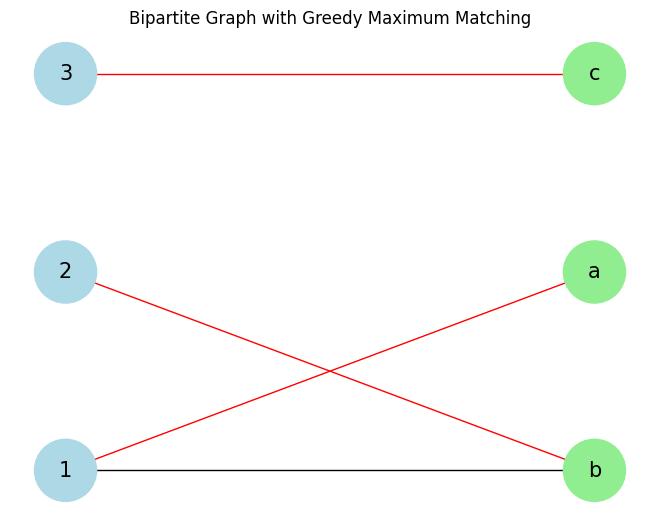

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

# Create a bipartite graph
def create_bipartite_graph():
    B = nx.Graph()
    # Add nodes with the attribute "bipartite"
    top_nodes = {1, 2, 3}
    bottom_nodes = {'a', 'b', 'c'}
    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    # Add edges between nodes in the two sets
    edges = [(1, 'a'), (1, 'b'), (2, 'b'), (3, 'c')]
    B.add_edges_from(edges)

    return B, top_nodes, bottom_nodes

# Greedy algorithm for maximum matching
def greedy_maximum_matching(B, top_nodes, bottom_nodes):
    matching = set()  # To store the matching pairs
    matched_nodes = set()  # To keep track of matched nodes

    # Iterate over edges greedily
    for u, v in B.edges():
        if u not in matched_nodes and v not in matched_nodes:
            matching.add((u, v))
            matched_nodes.add(u)
            matched_nodes.add(v)

    return matching

# Step 1: Create a bipartite graph
B, top_nodes, bottom_nodes = create_bipartite_graph()

# Step 2: Check if the graph is bipartite
is_bipartite = bipartite.is_bipartite(B)
print(f"Is the graph bipartite? {is_bipartite}")

# Step 3: Perform greedy maximum matching if bipartite
if is_bipartite:
    # Apply the greedy maximum matching algorithm
    matching = greedy_maximum_matching(B, top_nodes, bottom_nodes)
    print(f"Greedy Maximum Matching: {matching}")

    # Step 4: Plot the graph with matching edges highlighted
    pos = nx.bipartite_layout(B, top_nodes)

    # Highlight matching edges in red
    matching_edges = list(matching)
    edge_colors = ['red' if (u, v) in matching_edges or (v, u) in matching_edges else 'black' for u, v in B.edges()]

    # Draw the graph with the highlighted matching
    nx.draw(B, pos, with_labels=True, edge_color=edge_colors, node_color=['lightblue' if n in top_nodes else 'lightgreen' for n in B.nodes()], node_size=2000, font_size=15)
    plt.title("Bipartite Graph with Greedy Maximum Matching")
    plt.show()
else:
    print("The graph is not bipartite.")

#ksingles

In [ ]:
import re
from collections import defaultdict
import numpy as np

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().lower() # Read text and convert to lowercase
        text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with single space
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
        return text

def generate_4_shingles(text):
    words = text.split() # Split text into words
    shingles = []
    seen_shingles = set() # To track seen shingles and maintain order

    for i in range(len(words) - 3):
        shingle = ' '.join(words[i:i+4]) # Create 4-shingle
        if shingle not in seen_shingles:
            shingles.append(shingle)
            seen_shingles.add(shingle)

    return shingles

def create_incidence_matrix(file_paths):
    shingle_counts = defaultdict(int) # Dictionary to store shingle counts
    all_shingles = [] # List to store all shingles in order of appearance

    # Step 1: Count shingles and collect all unique shingles in order
    for file_path in file_paths:
        text = read_text_file(file_path)
        shingles = generate_4_shingles(text)

        for shingle in shingles:
            shingle_counts[shingle] += 1
            if shingle not in all_shingles:
                all_shingles.append(shingle)

    num_files = len(file_paths)
    num_shingles = len(all_shingles)

    # Step 2: Create incidence matrix
    incidence_matrix = np.zeros((num_shingles, num_files), dtype=int)

    for j, file_path in enumerate(file_paths):
        text = read_text_file(file_path)
        shingles = generate_4_shingles(text)

        for i, shingle in enumerate(all_shingles):
            if shingle in shingles:
                incidence_matrix[i, j] = 1

    return all_shingles, incidence_matrix

def print_incidence_matrix(file_paths):
    shingles, incidence_matrix = create_incidence_matrix(file_paths)

    # Print header
    print("{:<40} {:<10} {:<10} {:<10}".format("Shingles", "txt1", "txt2", "txt3"))
    print("-" * 70)

    # Print matrix
    for idx, shingle in enumerate(shingles):
        print("{:<40} {:<10} {:<10} {:<10}".format(shingle, incidence_matrix[idx, 0], incidence_matrix[idx, 1], incidence_matrix[idx, 2]))

# Example usage:
file_paths = ["/content/drive/MyDrive/1.txt", "/content/drive/MyDrive/2.txt", "/content/drive/MyDrive/3.txt"] # Replace with your file paths

print_incidence_matrix(file_paths)

#min hashing

In [ ]:
# text=input("Enter a string: ")
# kval =int(input("Enter k-value: "))
text="hello"
kval=2
def shinglewithsepr(text, kval):
  shingles = []
  tokens = text.split(" ")
  for i in range(0, len(tokens), kval):
      shingle = tokens[i:i + kval]
      shingles.append(shingle)
  #print("Shingles using separator: ", shingles)
  return shingles
def shinglewithoutsepr(text, kval):
  shingles = []
  for i in range(len(text)-kval+1):
      shingle = text[i:i + kval]
      shingles.append(shingle)
  #print("Shingles without using separator: ", shingles)
  return shingles
wordshingles = shinglewithsepr(text, kval)
charshingles = shinglewithoutsepr(text, kval)



import pandas as pd
import numpy as np
import random
# with open("1.txt", "r") as file:
#   doc1 = file.read()
# print(doc1)
# with open("2.txt", "r") as file:
#   doc2 = file.read()
# print(doc2)
doc1 = "Today is Monday."
doc2 = "Today is a good day."
doc3 = "Good day."
doc4 = "Tomorrow will be a good day."
kval =3
shingle1 = shinglewithoutsepr(doc1, kval)
shingle2 = shinglewithoutsepr(doc2, kval)
shingle3 = shinglewithoutsepr(doc3, kval)
shingle4 = shinglewithoutsepr(doc4, kval)
all_shingles = list(set(shingle1 + shingle2+shingle3+shingle4))
print("Shingle 1:", shingle1)
print("Shingle 2:", shingle2)
print("Shingle 3:", shingle3)
print("Shingle 4:", shingle4)
print("All shingles:", all_shingles)
df = pd.DataFrame(columns=["Shingle", "doc1", "doc2","doc3","doc4"])
df["Shingle"] = all_shingles
df.fillna(0, inplace=True)
for i in range(len(shingle1)):
    df.loc[df["Shingle"] == shingle1[i], "doc1"] = 1
for i in range(len(shingle2)):
    df.loc[df["Shingle"] == shingle2[i], "doc2"] = 1
for i in range(len(shingle3)):
    df.loc[df["Shingle"] == shingle3[i], "doc3"] = 1
for i in range(len(shingle4)):
    df.loc[df["Shingle"] == shingle4[i], "doc4"] = 1
df["Hash1"] = df.index.map(lambda x: (17 * int(x) + 11) % len(df))
df["Hash2"] = df.index.map(lambda x: (7 * int(x) + 11) % len(df))
print(len(df))
print(df)




sig = np.full((2,4), np.inf)
for index, row in df.iterrows():
   if row["doc1"] == 1:
       sig[0, 0] = min(sig[0, 0], row["Hash1"])
       sig[1, 0] = min(sig[1, 0], row["Hash2"])
   if row["doc2"] == 1:
       sig[0, 1] = min(sig[0, 1], row["Hash1"])
       sig[1, 1] = min(sig[1, 1], row["Hash2"])
   if row["doc3"] == 1:
       sig[0, 2] = min(sig[0, 2], row["Hash1"])
       sig[1, 2] = min(sig[1, 2], row["Hash2"])
   if row["doc4"] == 1:
       sig[0, 3] = min(sig[0, 3], row["Hash1"])
       sig[1, 3] = min(sig[1, 3], row["Hash2"])
print("Signature matrix =\n",sig)

#social network

In [ ]:
!pip install --upgrade network


%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))



data = pd.read_csv('/content/Time-Wasters on Social Media.csv')
print(data.head)


edges = data.groupby(['Platform', 'Scroll Rate']).agg({'Total Time Spent':'sum'}).reset_index()
edges.sort_values('Total Time Spent', ascending=False).head()



weighted_degrees = dict(nx.degree(GOT,weight='Total Time Spent'))
max_degree = max(weighted_degrees.values())


GOT = nx.from_pandas_edgelist(edges,
                            source='Platform',
                            target='Scroll Rate',
                            edge_attr='Total Time Spent' )



import seaborn as sns

h = plt.hist(weighted_degrees.values(), bins = 30)

subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>300])


num1_nodes = subG.number_of_nodes()
num1_edges = subG.number_of_edges()

print('Number of nodes:', num1_nodes)
print('Number of edges:', num1_edges)


pos = nx.spring_layout(subG,weight='Total Time Spent',iterations=20, k = 5)


plt.axis('off')
plt.title('Time wasters on Social Media',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')
nx.draw_networkx_labels(subG, pos, {n: str(n).replace('.', '\n') for n in subG.nodes() if weighted_degrees[n] > 100}, font_size=10)
for e in subG.edges(data=True):
    if e[2]['Total Time Spent']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['Total Time Spent']/100,edge_color='#707070')



top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='Total Time Spent')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank(subG, weight='Total Time Spent')), orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='Total Time Spent')),orient='index')
